<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/gaussian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Gaussian Process**

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## **Characterisations of a Gaussian Process**

* A Gaussian process is a stochastic process (a collection of random variables indexed by time or space), such that every finite collection of those random variables has a multivariate normal distribution, i.e. **every finite linear combination of them is normally distributed**. 

* The distribution of a Gaussian process is the joint distribution of all those (infinitely many) random variables, and as such, it is a distribution over functions with a continuous domain, e.g. time or space.

* Gaussian Processes are a class of stationary, zero-mean stochastic processes which are completely dependent on their autocovariance functions. This class of models can be used for both regression and classification tasks.

* Gaussian Processes provide estimates about uncertainty, for example giving an estimate of how sure an algorithm is that an item belongs to a class or not.

* In order to deal with situations which embed a certain degree of uncertainty is typically made use of probability distributions.

* Gaussian processes can allow us to describe probability distributions of which we can later update the distribution using Bayes Rule once we gather new training data.



## **Relation to Wiener Process & Brownian Motion**

* A Wiener process (aka Brownian motion) is the integral of a white noise generalized Gaussian process. It is not stationary, but it has stationary increments.

* The Ornstein–Uhlenbeck process is a stationary Gaussian process.

* The Brownian bridge is (like the Ornstein–Uhlenbeck process) an example of a Gaussian process whose increments are not independent.

* The fractional Brownian motion is a Gaussian process whose covariance function is a generalisation of that of the Wiener process.

## **Gaussian Processes for Machine Learning**

http://katbailey.github.io/post/gaussian-processes-for-dummies/

**Introduction**

* Bayesian linear regression provides a probabilistic approach to this by finding a distribution over the parameters that gets updated whenever new data points are observed. The GP approach, in contrast, is a non-parametric approach, in that it finds a distribution over the possible functions f(x) that are consistent with the observed data.

* As with all Bayesian methods it begins with a prior distribution and updates this as data points are observed, producing the posterior distribution over functions.

**Covariance Matrix**

* Looking at the average of the product of how two random variables deviate from their average.

* “Covariance” indicates the direction of the linear relationship between variables. “Correlation” on the other hand measures both the strength and direction of the linear relationship between two variables.

* Correlation is a function of the covariance. What sets them apart is the fact that correlation values are standardized whereas, covariance values are not. You can obtain the correlation coefficient of two variables by dividing the covariance of these variables by the product of the standard deviations of the same values.

* If the random variables are independent then their covariance is zero. Their joint distribution in that case is just the product of their two distributions.

* With joint distributions we can calculate marginal and conditional probability distributions

**Cholesky Decomposition**

* Taking the square root of a matrix. If I have some matrix A then the Cholesky decomposition will give me a new matrix L such that LL* = A, where L is a lower triangular matrix with real and positive diagonal entries, and L* denotes the conjugate transpose of L.

* There are special properties that all of these matrices need to have, for example A must be positive-definite and L must be a lower-triangular matrix.

* Cholesky Decomposition is a decomposition of a **Hermitian, positive-definite matrix** into the product of a lower triangular matrix and its conjugate transpose, which is useful for efficient numerical solutions, e.g., Monte Carlo simulations. When it is applicable, the Cholesky decomposition is roughly twice as efficient as the LU decomposition for solving systems of linear equations.

**Kernel Function**

* Perform the calculations using our kernel function — for example the Radial Basis Function. 

* The kernel function is what we use to measure the covariance of the variables. Different functions have different properties and choosing the right one seems to be both a science and an art. 

**Example**

* Below we define the points at which our functions will be evaluated, 50 evenly spaced points between -5 and 5. 

* We also define the kernel function which uses the Squared Exponential, a.k.a Gaussian, a.k.a. Radial Basis Function kernel. 

* It calculates the squared distance between points and converts it into a measure of similarity, controlled by a tuning parameter. Note that we are assuming a mean of 0 for our prior.

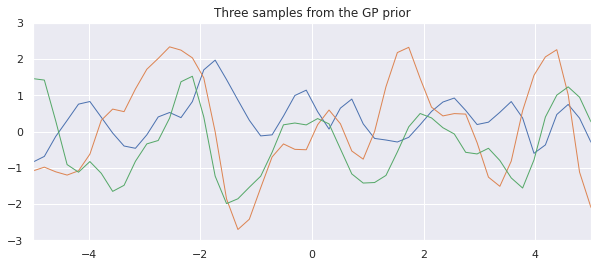

In [6]:
# Test data
n = 50
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

# Define the kernel function
def kernel(a, b, param):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/param) * sqdist)

param = 0.1
K_ss = kernel(Xtest, Xtest, param)

# Get cholesky decomposition (square root) of the
# covariance matrix
L = np.linalg.cholesky(K_ss + 1e-15*np.eye(n))
# Sample 3 sets of standard normals for our test points,
# multiply them by the square root of the covariance matrix
f_prior = np.dot(L, np.random.normal(size=(n,3)))

# Now let's plot the 3 sampled functions.
sns.set(rc={'figure.figsize':(10, 4), "lines.linewidth": 1.0})
plt.plot(Xtest, f_prior)
plt.axis([-5, 5, -3, 3])
plt.title('Three samples from the GP prior')
plt.show()

* Note that the K_ss variable here corresponds to K<sub>* *</sub> in the equation above for the joint probability. It will be used again below, along with K and K*

* Now we’ll observe some data. The actual function generating the y values from our x values, unbeknownst to our model, is the sin function. 

* We generate the output at our 5 training points, do the equivalent of the above-mentioned 4 pages of matrix algebra in a few lines of python code, sample from the posterior and plot it.

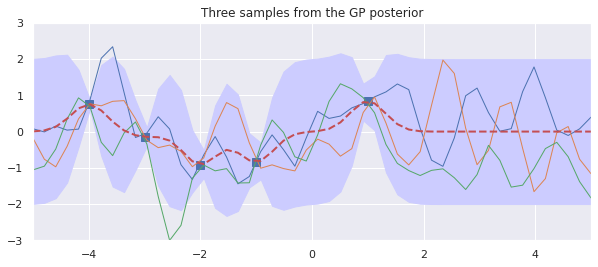

In [15]:
# Noiseless training data
Xtrain = np.array([-4, -3, -2, -1, 1]).reshape(5,1)
ytrain = np.sin(Xtrain)

# Apply the kernel function to our training points
K = kernel(Xtrain, Xtrain, param)
L = np.linalg.cholesky(K + 0.00005*np.eye(len(Xtrain)))

# Compute the mean at our test points.
K_s = kernel(Xtrain, Xtest, param)
Lk = np.linalg.solve(L, K_s)
mu = np.dot(Lk.T, np.linalg.solve(L, ytrain)).reshape((n,))

# Compute the standard deviation so we can plot it
s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
stdv = np.sqrt(s2)
# Draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ss + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,3)))

sns.set(rc={'figure.figsize':(10, 4), "lines.linewidth": 1.0})
plt.plot(Xtrain, ytrain, 'bs', ms=8)
plt.plot(Xtest, f_post)
plt.gca().fill_between(Xtest.flat, mu-2*stdv, mu+2*stdv, color="#CCCCFF")
plt.plot(Xtest, mu, 'r--', lw=2)
plt.axis([-5, 5, -3, 3])
plt.title('Three samples from the GP posterior')
plt.show()

* the training points (the blue squares) have “reined in” the set of possible functions: the ones we have sampled from the posterior all go through those points. 

* The dotted red line shows the mean output and the grey area shows 2 standard deviations from the mean. 

* Note that this is 0 at our training points (because we did not add any noise to our data). 

* Also note how things start to go a bit wild again to the right of our last training point x = 1 - that won’t get reined in until we observe some data over there.